In [1]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/combinedData.csv')
target = pd.read_csv('./data/combinedTarget.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,13,14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data.merge(target, how='left',on=['Provider','Set'])

In [ ]:
data.groupby('BeneID')['Provider'].nunique()

In [ ]:
physData = data[['AttendingPhysician','OperatingPhysician','OtherPhysician','Provider','State']]
physMelt = physData.melt(id_vars=['Provider','State'],var_name='Type', value_name='Doctor').dropna(axis=0)
physNet = physMelt.groupby('Doctor')['State'].nunique().reset_index()

In [ ]:
physNet

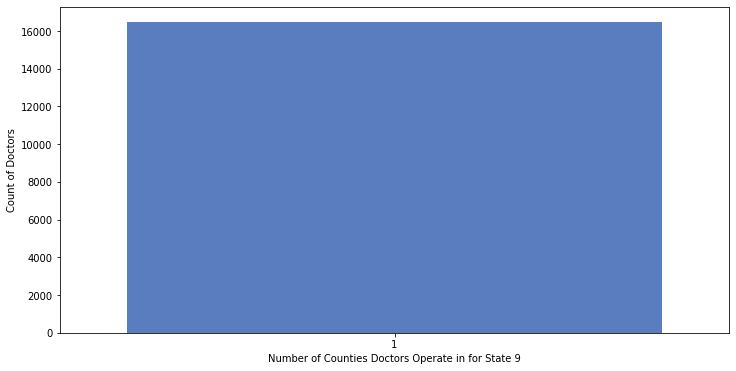

In [5]:
physData = data[['AttendingPhysician','OperatingPhysician','OtherPhysician','State','County']]
physMelt = physData.melt(id_vars=['State','County'],var_name='Type', value_name='Doctor').dropna(axis=0)
physNet = physMelt.groupby(['Doctor','State'])['County'].nunique().reset_index()

plt.figure(figsize=(12,6))

for state in physNet.State.unique():
    filename = "./visualizations/plots/crossing_county/Doctors/State_" + str(state) + ".png"
    ax1 = sns.countplot(x = 'County', data=physNet[physNet.State==state], palette = 'muted');
    ax1.set(xlabel='Number of Counties Doctors Operate in for State ' + str(state), 
            ylabel='Count of Doctors');
    ax1.figure.savefig(filename,bbox_inches='tight')

In [ ]:
physNet.groupby('State').count()

In [ ]:
beneData = data[['BeneID','Provider','State']]
beneNet = beneData.groupby(['BeneID','Provider'])['State'].nunique().reset_index()

In [ ]:
plt.figure(figsize=(12,6))


ax1 = sns.countplot(x = 'State', data=beneNet, palette = 'muted')

ax1.set(xlabel='Number of States', ylabel='Number of Doctors')

#ax1.figure.savefig("./visualizations/plots/multistateDoctors.png",bbox_inches='tight')

In [ ]:
beneNet

In [ ]:
beneData = data[['BeneID','Provider','State','County']]
beneNet = beneData.groupby(['BeneID','Provider'])['County'].nunique().reset_index()

plt.figure(figsize=(12,6))


ax1 = sns.countplot(x = 'County', data=beneNet, palette = 'muted')

ax1.set(xlabel='Number of Counties', ylabel='Number of Doctors')

#ax1.figure.savefig("./visualizations/plots/multistateDoctors.png",bbox_inches='tight')

In [ ]:
provData = data[['Provider','State','County']]
provNet = provData.groupby(['Provider'])['State'].nunique().reset_index()

plt.figure(figsize=(12,6))


ax1 = sns.countplot(x = 'State', data=provNet, palette = 'muted')

ax1.set(xlabel='Number of States', ylabel='Number of Providers operating')

ax1.figure.savefig("./visualizations/plots/multistateProviders.png",bbox_inches='tight')

In [ ]:
provData = data[['Provider','State','County']]
provNet = provData.groupby(['Provider','State'])['County'].nunique().reset_index()

plt.figure(figsize=(12,6))

for state in provNet.State.unique():
    filename = "./visualizations/plots/crossing_county/Providers/State_" + str(state) + ".png"
    ax1 = sns.countplot(x = 'County', data=provNet[provNet.State==state], palette = 'muted');
    ax1.set(xlabel='Number of Counties Providers Operate in for State ' + str(state), 
            ylabel='Count of Providers');
    ax1.figure.savefig(filename,bbox_inches='tight')

In [6]:
physData = data[['AttendingPhysician','OperatingPhysician','OtherPhysician','State','County']]
physMelt = physData.melt(id_vars=['State','County'],var_name='Type', value_name='Doctor').dropna(axis=0)
physNet = physMelt.groupby(['State','County'])['Doctor'].nunique().reset_index()


In [7]:
physNet

,State,County,Doctor
0,1,0,93
1,1,10,494
2,1,20,76
3,1,30,63
4,1,40,36
...,...,...,...
3113,54,770,48
3114,54,830,19
3115,54,870,2
3116,54,880,3


In [21]:
california = physNet[physNet.State==5]

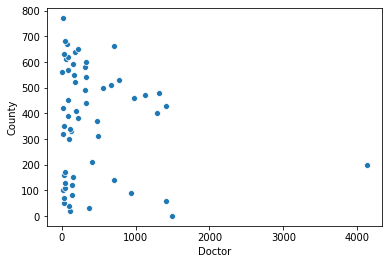

In [23]:
sns.scatterplot(x = 'Doctor', y = 'County',data = california)

In [ ]:
for state in physNet.State.unique():
    filename = "./visualizations/plots/num_doctors/State_" + str(state) + ".png"
    ax1 = sns.countplot(x = 'County', data=physNet[physNet.State==state], palette = 'muted');
    ax1.set(xlabel='Number of Doctors' + str(state), 
            ylabel='Count of Doctors');
    ax1.figure.savefig(filename,bbox_inches='tight')

In [26]:
data.WhetherDead.value_counts()

0    688432
1      5171
Name: WhetherDead, dtype: int64

In [29]:
5171/(5171+688432)*100


0.7455273405680194